In [1]:
import pyspark.sql as pyspark_sql
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
# SparkSession creation
spark = pyspark_sql.SparkSession.builder.appName("Data_Visualization").getOrCreate()

# Visualize before Data cleaning

In [4]:
all_data = spark.read.csv("../data/all_data.csv", header=True, inferSchema=True)

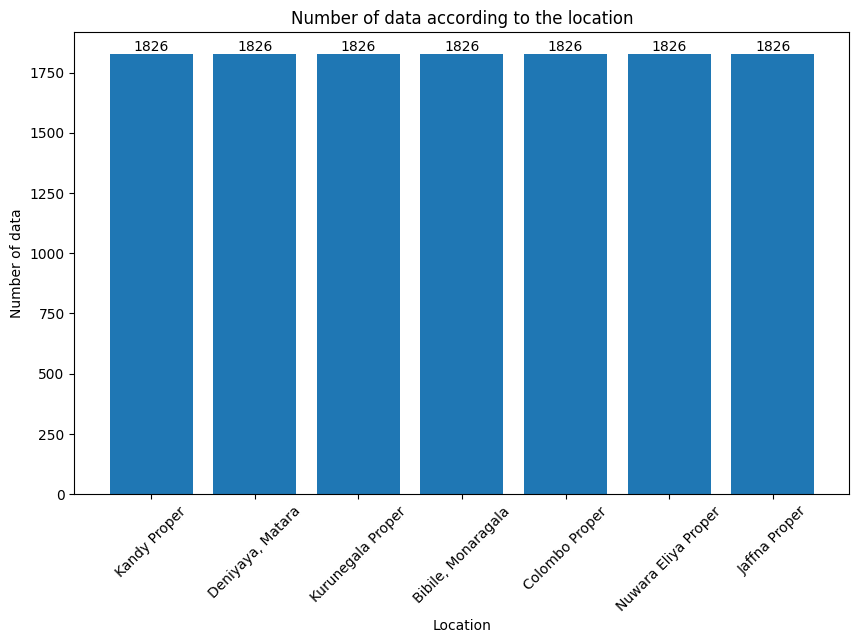

In [5]:
# Visualize a histogram of the number of data points according to location
location_count = all_data.groupBy("location").count().toPandas()

plt.figure(figsize=(10, 6))
plt.bar(location_count["location"], location_count["count"])
plt.xlabel("Location")
plt.ylabel("Number of data")
plt.title("Number of data according to the location")
plt.xticks(rotation=45)

# Add counts to each bar
for i, count in enumerate(location_count["count"]):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [6]:
# Group data by location and get the start date and end date
all_data.groupBy("location")\
    .agg(F.min("current_date").alias("start_date"),
         F.max("current_date").alias("end_date")).show()

+-------------------+----------+----------+
|           location|start_date|  end_date|
+-------------------+----------+----------+
|       Kandy Proper|2019-01-01|2023-12-31|
|   Deniyaya, Matara|2019-01-01|2023-12-31|
|  Kurunegala Proper|2019-01-01|2023-12-31|
| Bibile, Monaragala|2019-01-01|2023-12-31|
|     Colombo Proper|2019-01-01|2023-12-31|
|Nuwara Eliya Proper|2019-01-01|2023-12-31|
|      Jaffna Proper|2019-01-01|2023-12-31|
+-------------------+----------+----------+



##### Observation :

We have data available for the daily emission of formaldehyde(HCHO) gas from seven cities: Kandy, Matara(Deniyaya), Kurunegala, Monaragala(Bibile), Colombo, Nuwara Eliya, and Jaffna. This dataset covers the period from January 1st, 2019, to December 31st, 2023, providing 1826 days of data for each city.

### Checking Null Values

In [7]:
# Number of null values in each column for entire dataset
all_data.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in all_data.columns]).show()

+------------+--------+------------+---------+
|hcho_reading|location|current_date|next_date|
+------------+--------+------------+---------+
|        4864|       0|           0|        0|
+------------+--------+------------+---------+



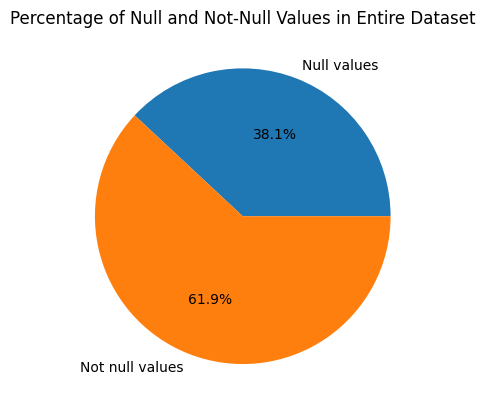

In [8]:
# Visulaize a pie chart with null values count for hcho_reading column in entire dataset
null_values_all = all_data.filter(F.col("hcho_reading").isNull()).count()
not_null_values_all = all_data.filter(F.col("hcho_reading").isNotNull()).count()

plt.pie([null_values_all, not_null_values_all], labels=["Null values", "Not null values"], autopct='%1.1f%%')
plt.title("Percentage of Null and Not-Null Values in Entire Dataset")
plt.show()

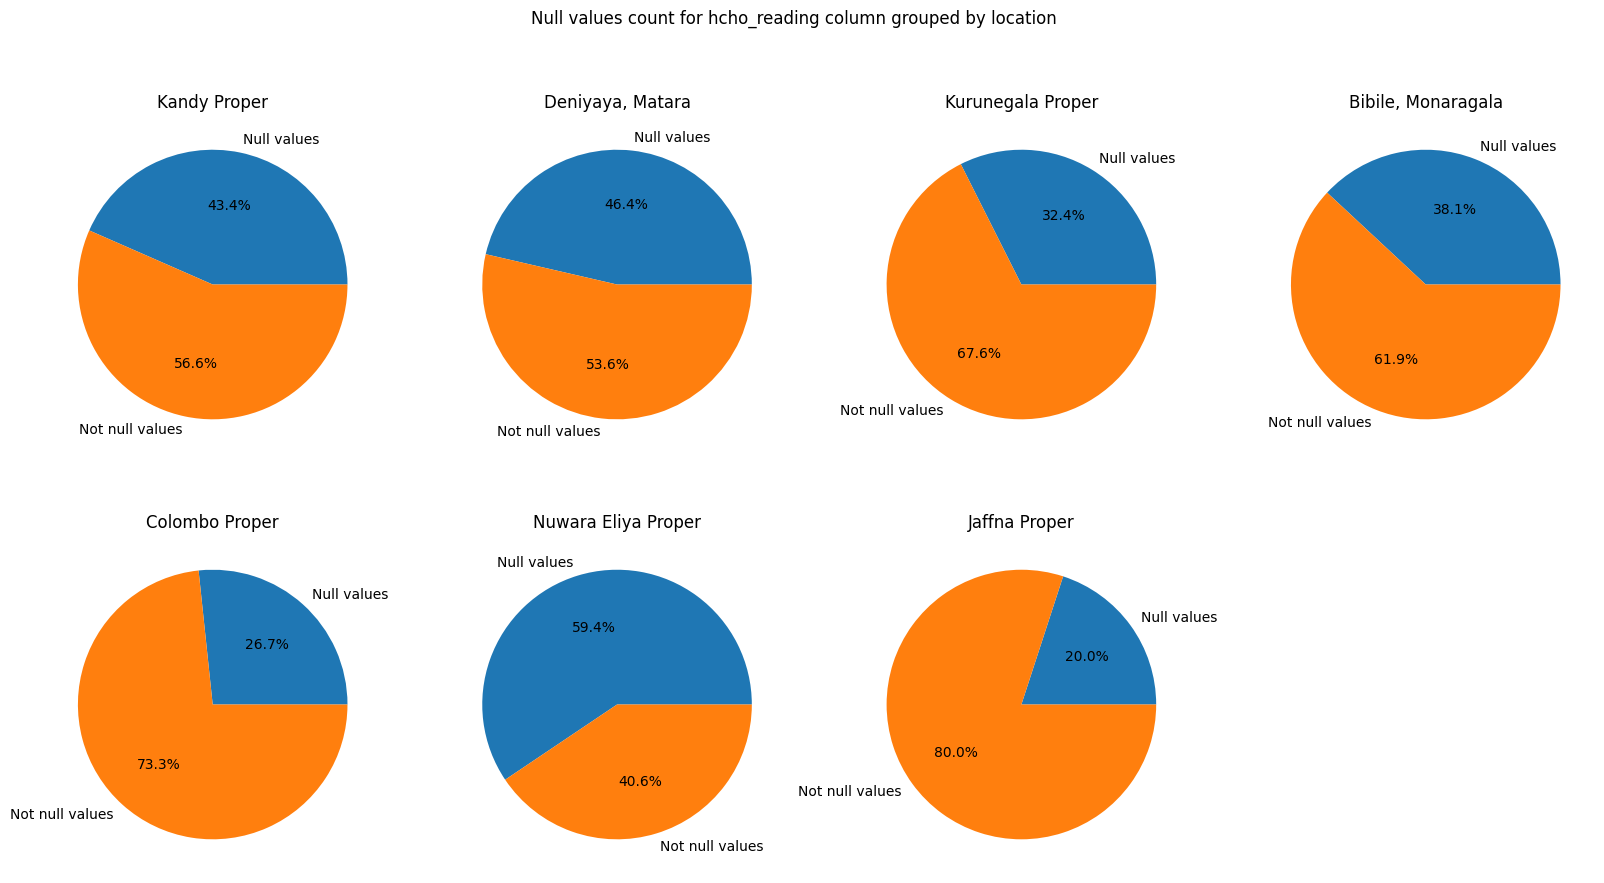

In [10]:
# Draw pie charts to look for null values grouped by location
null_values = all_data.filter(F.col("hcho_reading").isNull()).groupBy("location").count().toPandas()
not_null_values = all_data.filter(F.col("hcho_reading").isNotNull()).groupBy("location").count().toPandas()

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Null values count for hcho_reading column grouped by location")

for i, ax in enumerate(axs.flat):
    if i < len(null_values):
        ax.pie([null_values["count"][i], not_null_values["count"][i]],
               labels=["Null values", "Not null values"], autopct='%1.1f%%')
        ax.set_title(null_values["location"][i])
    # Remove the last subplot
    else:
        fig.delaxes(ax)
    
plt.show()

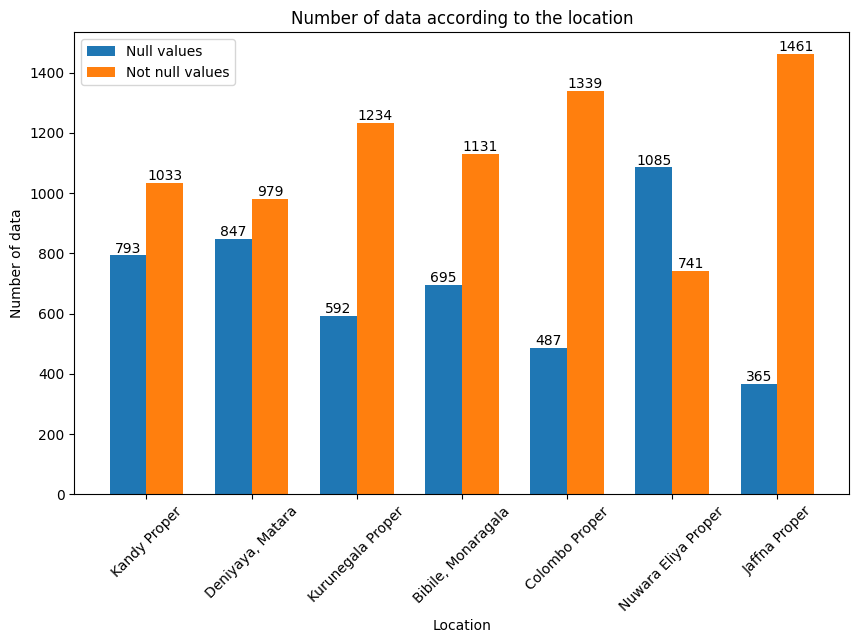

In [11]:
# Draw bar graph to visualize the distribution of null and not null values for each location
plt.figure(figsize=(10, 6))

# Set the x coordinates for the bars
x = np.arange(len(location_count["location"]))

# Plot the bars for null values
plt.bar(x - 0.35/2, null_values["count"], width=0.35, label='Null values')

# Plot the bars for not null values
plt.bar(x + 0.35/2, not_null_values["count"], width=0.35, label='Not null values')

plt.xlabel("Location")
plt.ylabel("Number of data")
plt.title("Number of data according to the location")
plt.xticks(x,location_count["location"],rotation=45)

# Add counts to each bar
for i, count in enumerate(location_count["count"]):
    plt.text(i - 0.35/2, null_values["count"][i], str(null_values["count"][i]), ha='center', va='bottom')
    plt.text(i + 0.35/2, not_null_values["count"][i], str(not_null_values["count"][i]), ha='center', va='bottom')

plt.legend()
plt.show()


##### Observation :

By studying the pie charts, null values account for more than 20% of the data in each city, and 38.1% of the entire dataset consists of null values. Dropping these null values is not a viable solution as it would result in significant data loss. Instead, we should explore alternative techniques for replacing missing values, such as utilizing various time series data imputation methods.